# CONFLUENCE Tutorial: Lumped Basin Workflow (Bow River at Banff)

This notebook walks through the complete CONFLUENCE workflow for a lumped basin model using the Bow River at Banff as an example. We'll execute each step individually to understand what's happening at each stage.

## Introduction to CONFLUENCE

CONFLUENCE is designed to address a fundamental challenge in hydrological modeling: the overwhelming number of decisions required to set up and run a hydrological model.

### The Challenge of Hydrological Modeling Decisions

Hydrological modeling involves numerous interconnected decisions at every stage:
- **Domain Definition**: What area should we model? How should we delineate the watershed?
- **Data Processing**: Which forcing datasets? What temporal and spatial resolution? 
- **Model Selection**: Which hydrological model? What process representations?
- **Parameterization**: Which parameters to calibrate? What are reasonable ranges?
- **Evaluation**: What metrics? Which observation datasets?

Each decision impacts the others, creating a complex decision tree that can be overwhelming for both novice and experienced modelers.

### How CONFLUENCE Helps

CONFLUENCE addresses this complexity by:
1. **Organizing the workflow** into clear, sequential steps
2. **Standardizing data structures** across different models and datasets
4. **Maintaining detailed provenance** of all decisions made

### CONFLUENCE's Code Structure: Organized by Function

CONFLUENCE uses an object-oriented design where different aspects of hydrological modeling are handled by specialized classes called "managers". This is like having different experts, each responsible for their domain:

```python
# Each manager handles a specific task
project_manager = ProjectManager(config, logger)     # Project setup
domain_manager = DomainManager(config, logger)       # Watershed delineation  
data_manager = DataManager(config, logger)           # Data processing
model_manager = ModelManager(config, logger)         # Model operations
```

Throughout this tutorial, you'll see how each manager handles its part of the workflow, working together to complete the full modeling process.


## Overview of This Tutorial

We'll work through the simplest case in hydrological modeling: a lumped basin model. This treats the entire watershed as a single unit, making it an ideal starting point for understanding the CONFLUENCE workflow.

We'll run through:
1. Project setup and configuration
2. Domain definition (watershed delineation)
3. Data acquisition (forcings and attributes)
4. Model preprocessing
5. Model execution
6. Results visualization

## 1. Setup and Import Libraries

In [1]:
# Import required libraries
import sys
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import contextily as cx
import xarray as xr

# Add CONFLUENCE to path
confluence_path = Path('../').resolve()
sys.path.append(str(confluence_path))

# Import main CONFLUENCE class
from CONFLUENCE import CONFLUENCE

# Set up plotting style
plt.style.use('default')
%matplotlib inline

## 2. Initialize CONFLUENCE
First, let's set up our directories and load the configuration. CONFLUENCE uses a centralized configuration file that controls all aspects of the modeling workflow.

In [2]:
# Set directory paths
CONFLUENCE_CODE_DIR = confluence_path
CONFLUENCE_DATA_DIR = Path('/work/comphyd_lab/data/CONFLUENCE_data')  # ← User should modify this path

# Verify paths exist
if not CONFLUENCE_CODE_DIR.exists():
    raise FileNotFoundError(f"CONFLUENCE code directory not found: {CONFLUENCE_CODE_DIR}")

if not CONFLUENCE_DATA_DIR.exists():
    print(f"Data directory doesn't exist. Creating: {CONFLUENCE_DATA_DIR}")
    CONFLUENCE_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Load and update configuration
config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_template.yaml'

# Read config file and update paths
with open(config_path, 'r') as f:
    config_dict = yaml.safe_load(f)

config_dict['CONFLUENCE_CODE_DIR'] = str(CONFLUENCE_CODE_DIR)
config_dict['CONFLUENCE_DATA_DIR'] = str(CONFLUENCE_DATA_DIR)

# Save updated config to a temporary file
temp_config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_notebook.yaml'
with open(temp_config_path, 'w') as f:
    yaml.dump(config_dict, f)

# Initialize CONFLUENCE
confluence = CONFLUENCE(temp_config_path)

# Display configuration
print("=== Directory Configuration ===")
print(f"Code Directory: {CONFLUENCE_CODE_DIR}")
print(f"Data Directory: {CONFLUENCE_DATA_DIR}")
print("\n=== Key Configuration Settings ===")
print(f"Domain Name: {confluence.config['DOMAIN_NAME']}")
print(f"Pour Point: {confluence.config['POUR_POINT_COORDS']}")
print(f"Spatial Mode: {confluence.config['SPATIAL_MODE']}")
print(f"Model: {confluence.config['HYDROLOGICAL_MODEL']}")
print(f"Simulation Period: {confluence.config['EXPERIMENT_TIME_START']} to {confluence.config['EXPERIMENT_TIME_END']}")

14:56:31 - INFO - ============================================================


2025-05-11 14:56:31,340 - confluence_general - INFO - ============================================================


14:56:31 - INFO - CONFLUENCE Logging Initialized


2025-05-11 14:56:31,342 - confluence_general - INFO - CONFLUENCE Logging Initialized


14:56:31 - INFO - Domain: Bow_at_Banff_lumped


2025-05-11 14:56:31,344 - confluence_general - INFO - Domain: Bow_at_Banff_lumped


14:56:31 - INFO - Experiment ID: run_1


2025-05-11 14:56:31,346 - confluence_general - INFO - Experiment ID: run_1


14:56:31 - INFO - Log Level: INFO


2025-05-11 14:56:31,347 - confluence_general - INFO - Log Level: INFO


14:56:31 - INFO - Log File: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/_workLog_Bow_at_Banff_lumped/confluence_general_Bow_at_Banff_lumped_20250511_145631.log


2025-05-11 14:56:31,349 - confluence_general - INFO - Log File: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/_workLog_Bow_at_Banff_lumped/confluence_general_Bow_at_Banff_lumped_20250511_145631.log


14:56:31 - INFO - ============================================================


2025-05-11 14:56:31,350 - confluence_general - INFO - ============================================================


14:56:31 - INFO - Configuration logged to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/_workLog_Bow_at_Banff_lumped/config_Bow_at_Banff_lumped_20250511_145631.yaml


2025-05-11 14:56:31,373 - confluence_general - INFO - Configuration logged to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/_workLog_Bow_at_Banff_lumped/config_Bow_at_Banff_lumped_20250511_145631.yaml


14:56:31 - INFO - Initializing CONFLUENCE system


2025-05-11 14:56:31,376 - confluence_general - INFO - Initializing CONFLUENCE system


14:56:31 - INFO - Configuration loaded from: /home/darri.eythorsson/code/CONFLUENCE/0_config_files/config_notebook.yaml


2025-05-11 14:56:31,378 - confluence_general - INFO - Configuration loaded from: /home/darri.eythorsson/code/CONFLUENCE/0_config_files/config_notebook.yaml


14:56:31 - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


2025-05-11 14:56:31,380 - confluence_general - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


14:56:31 - INFO - CONFLUENCE system initialized successfully


2025-05-11 14:56:31,720 - confluence_general - INFO - CONFLUENCE system initialized successfully


=== Directory Configuration ===
Code Directory: /home/darri.eythorsson/code/CONFLUENCE
Data Directory: /work/comphyd_lab/data/CONFLUENCE_data

=== Key Configuration Settings ===
Domain Name: Bow_at_Banff_lumped
Pour Point: 51.1722/-115.5717
Spatial Mode: Lumped
Model: SUMMA
Simulation Period: 2018-01-01 01:00 to 2022-12-31 23:00


## 3. Project Setup - Organizing the Modeling Workflow
The first step in any CONFLUENCE workflow is to establish a well-organized project structure. This might seem trivial, but it's crucial for:

- Maintaining consistency across different experiments
- Ensuring all components can find required files
- Enabling reproducibility
- Facilitating collaboration

In [3]:
# Step 1: Project Initialization
print("=== Step 1: Project Initialization ===")

# Setup project
project_dir = confluence.managers['project'].setup_project()

# Create pour point
pour_point_path = confluence.managers['project'].create_pour_point()

# List created directories
print("\nCreated directories:")
for item in sorted(project_dir.iterdir()):
    if item.is_dir():
        print(f"  📁 {item.name}")

print("\nDirectory purposes:")
print("  📁 shapefiles: Domain geometry (watershed, pour points, river network)")
print("  📁 attributes: Static characteristics (elevation, soil, land cover)")
print("  📁 forcing: Meteorological inputs (precipitation, temperature)")
print("  📁 simulations: Model outputs")
print("  📁 evaluation: Performance metrics and comparisons")
print("  📁 plots: Visualizations")
print("  📁 optimisation: Calibration results")

=== Step 1: Project Initialization ===
14:56:31 - INFO - Setting up project for domain: Bow_at_Banff_lumped


2025-05-11 14:56:31,734 - confluence_general - INFO - Setting up project for domain: Bow_at_Banff_lumped


14:56:31 - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped


2025-05-11 14:56:31,783 - confluence_general - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped
2025-05-11 14:56:31,863 - pyogrio._io - INFO - Created 1 records


14:56:31 - INFO - Pour point shapefile created successfully: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/pour_point/Bow_at_Banff_lumped_pourPoint.shp


2025-05-11 14:56:31,866 - confluence_general - INFO - Pour point shapefile created successfully: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/pour_point/Bow_at_Banff_lumped_pourPoint.shp



Created directories:
  📁 _workLog_Bow_at_Banff_lumped
  📁 attributes
  📁 documentation
  📁 observations
  📁 optimisation
  📁 shapefiles

Directory purposes:
  📁 shapefiles: Domain geometry (watershed, pour points, river network)
  📁 attributes: Static characteristics (elevation, soil, land cover)
  📁 forcing: Meteorological inputs (precipitation, temperature)
  📁 simulations: Model outputs
  📁 evaluation: Performance metrics and comparisons
  📁 plots: Visualizations
  📁 optimisation: Calibration results


## 4. Geospatial Domain Definition and Analysis - A data acquisition 
Before we can delineate the watershed, we need elevation data. CONFLUENCE also acquires soil and land cover data at this stage for later use in the model.

In [4]:
# Step 2: Geospatial Domain Definition and Analysis
print("=== Step 2: Geospatial Domain Definition and Analysis ===")

# Acquire attributes
print("Acquiring geospatial attributes (DEM, soil, land cover)...")
confluence.managers['data'].acquire_attributes()



=== Step 2: Geospatial Domain Definition and Analysis ===
Acquiring geospatial attributes (DEM, soil, land cover)...
14:56:31 - INFO - Starting attribute acquisition


2025-05-11 14:56:31,877 - confluence_general - INFO - Starting attribute acquisition


14:56:31 - INFO - Acquiring elevation data


2025-05-11 14:56:31,892 - confluence_general - INFO - Acquiring elevation data


extract-gis.sh: WARNING! --account not provided, using `rpp-kshook` by default.
(2025-05-11 20:56:35) merit_hydro.sh: processing MERIT-Hydro GeoTIFF(s)...
(2025-05-11 20:56:35) merit_hydro.sh: creating cache directory under /home/darri.eythorsson/cache_Bow_at_Banff_lumped
(2025-05-11 20:56:35) merit_hydro.sh: creating output directory under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem
(2025-05-11 20:56:35) merit_hydro.sh: untarring MERIT-Hydro variables under /home/darri.eythorsson/cache_Bow_at_Banff_lumped
(2025-05-11 20:57:41) merit_hydro.sh: subsetting GeoTIFFs under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem


mkdir: cannot create directory ‘/home/darri.eythorsson/empty_dir’: File exists


(2025-05-11 20:57:42) merit_hydro.sh: deleting temporary files from /home/darri.eythorsson/cache_Bow_at_Banff_lumped
(2025-05-11 20:57:42) merit_hydro.sh: temporary files from /home/darri.eythorsson/cache_Bow_at_Banff_lumped are removed
(2025-05-11 20:57:42) merit_hydro.sh: results are produced under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem
14:57:42 - INFO - gistool completed successfully.


2025-05-11 14:57:42,602 - confluence_general - INFO - gistool completed successfully.


14:57:42 - INFO - Geospatial data acquisition process completed


2025-05-11 14:57:42,604 - confluence_general - INFO - Geospatial data acquisition process completed


14:57:42 - INFO - Acquiring land cover data


2025-05-11 14:57:42,606 - confluence_general - INFO - Acquiring land cover data


extract-gis.sh: WARNING! --account not provided, using `rpp-kshook` by default.
(2025-05-11 20:57:46) modis.sh: processing MODIS HDF(s)...
(2025-05-11 20:57:46) modis.sh: creating cache directory under /home/darri.eythorsson/cache_Bow_at_Banff_lumped
(2025-05-11 20:57:46) modis.sh: creating output directory under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/landclass
(2025-05-11 20:57:46) modis.sh: building virtual format (.vrt) of MODIS HDFs under /home/darri.eythorsson/cache_Bow_at_Banff_lumped


ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PRO

(2025-05-11 20:58:57) modis.sh: subsetting HDFs in GeoTIFF format under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/landclass
(2025-05-11 20:59:00) modis.sh: deleting temporary files from /home/darri.eythorsson/cache_Bow_at_Banff_lumped
(2025-05-11 20:59:00) modis.sh: temporary files from /home/darri.eythorsson/cache_Bow_at_Banff_lumped are removed
(2025-05-11 20:59:00) modis.sh: results are produced under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/landclass
14:59:00 - INFO - gistool completed successfully.


mkdir: cannot create directory ‘/home/darri.eythorsson/empty_dir’: File exists
2025-05-11 14:59:00,909 - confluence_general - INFO - gistool completed successfully.


14:59:00 - INFO - Geospatial data acquisition process completed


2025-05-11 14:59:00,911 - confluence_general - INFO - Geospatial data acquisition process completed


14:59:00 - INFO - Calculating land cover mode across years


2025-05-11 14:59:00,914 - confluence_general - INFO - Calculating land cover mode across years


Mode calculation complete. Result saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/landclass/domain_Bow_at_Banff_lumped_land_classes.tif
14:59:24 - INFO - Acquiring soil class data


2025-05-11 14:59:24,152 - confluence_general - INFO - Acquiring soil class data


extract-gis.sh: WARNING! --account not provided, using `rpp-kshook` by default.
(2025-05-11 20:59:28) soil_class.sh: processing Wouter's wonderful soil_class GeoTIFF(s)...
(2025-05-11 20:59:28) soil_class.sh: creating output directory under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/soilclass
(2025-05-11 20:59:28) soil_class.sh: subsetting GeoTIFFs under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/soilclass
(2025-05-11 20:59:29) soil_class.sh: deleting temporary files from /home/darri.eythorsson/cache_Bow_at_Banff_lumped
(2025-05-11 20:59:29) soil_class.sh: temporary files from /home/darri.eythorsson/cache_Bow_at_Banff_lumped are removed
(2025-05-11 20:59:29) soil_class.sh: results are produced under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/soilclass
14:59:29 - INFO - gistool completed successfully.


mkdir: cannot create directory ‘/home/darri.eythorsson/empty_dir’: File exists
2025-05-11 14:59:29,272 - confluence_general - INFO - gistool completed successfully.


14:59:29 - INFO - Geospatial data acquisition process completed


2025-05-11 14:59:29,274 - confluence_general - INFO - Geospatial data acquisition process completed


14:59:29 - INFO - Attribute acquisition completed successfully


2025-05-11 14:59:29,276 - confluence_general - INFO - Attribute acquisition completed successfully


## 5. Geospatial Domain Definition and Analysis - Delineation 

In [5]:
# Define domain
print(f"\nDelineating watershed using method: {confluence.config['DOMAIN_DEFINITION_METHOD']}")
watershed_path = confluence.managers['domain'].define_domain()

# Check outputs
print("\nDomain definition complete:")
print(f"  - Watershed defined: {watershed_path is not None}")


Delineating watershed using method: lumped
14:59:29 - INFO - Domain definition workflow starting with: lumped


2025-05-11 14:59:29,286 - confluence_general - INFO - Domain definition workflow starting with: lumped


14:59:29 - INFO - Starting geofabric lumped delineation


2025-05-11 14:59:29,288 - confluence_general - INFO - Starting geofabric lumped delineation


14:59:29 - INFO - Geofabric delineation completed successfully


2025-05-11 14:59:29,292 - confluence_general - INFO - Geofabric delineation completed successfully


14:59:29 - INFO - Starting lumped watershed delineation for Bow_at_Banff_lumped


2025-05-11 14:59:29,294 - confluence_general - INFO - Starting lumped watershed delineation for Bow_at_Banff_lumped


PitRemove version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem/domain_Bow_at_Banff_lumped_elv.tif has geographic coordinate system.
Nodata value input to create partition from file: -9999.000000
Nodata value recast to float used in partition raster: -9999.000000


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.


Processes: 1
Header read time: 0.035510
Data read time: 0.164531
Compute time: 0.288098
Write time: 0.104904
Total time: 0.593043
14:59:30 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/pitremove -z /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem/domain_Bow_at_Banff_lumped_elv.tif -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif


2025-05-11 14:59:30,434 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/pitremove -z /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem/domain_Bow_at_Banff_lumped_elv.tif -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif


D8FlowDir version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif has geographic coordinate system.
Nodata value input to create partition from file: -300000000549775575777803994281145270272.000000
Nodata value recast to float used in partition raster: -300000000549775575777803994281145270272.000000


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
All slopes evaluated. 28666 flats to resolve.
Draining flats towards lower adjacent terrain
...........................................................................
Draining flats away from higher adjacent terrain


Processors: 1
Header read time: 0.026039
Data read time: 0.034820
Compute Slope time: 0.289796
Write Slope time: 0.134648
Resolve Flat time: 0.705812
Write Flat time: 0.039872
Total time: 1.230986
14:59:32 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/d8flowdir -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -sd8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/sd8.tif


......
Setting directions
Iteration complete. Number of flats remaining: 95
Draining flats towards lower adjacent terrain
...
Draining flats away from higher adjacent terrain
..
Setting directions
2025-05-11 14:59:32,144 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/d8flowdir -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -sd8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/sd8.tif


AreaD8 version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.


Number of Processes: 1
Read time: 0.035312
Compute time: 0.333808
Write time: 0.073630
Total time: 0.442750
14:59:33 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/aread8 -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -ad8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif


2025-05-11 14:59:33,045 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/aread8 -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -ad8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif


Threshold version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif has geographic coordinate system.
Nodata value input to create partition from file: -1.000000
Nodata value recast to float used in partition raster: -1.000000
Compute time: 0.017447
14:59:33 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/threshold -ssa /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif -thresh 100


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
2025-05-11 14:59:33,595 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/threshold -ssa /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif -thresh 100


MoveOutletsToStreams version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
om Total time: 0.109240
14:59:34 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/moveoutletstostrm -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/pour_poin

This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
2025-05-11 14:59:34,165 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/moveoutletstostrm -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/pour_point/Bow_at_Banff_lumped_pourPoint.shp -om /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/om.shp


Gage Watershed version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Size: 1
Read time: 0.053697
Compute time: 0.066987
Write time: 0.051711
Total time: 0.172396
14:59:34 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/gagewatershed -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/om.shp -gw /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/watershed.tif -id /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/watershed_id.txt


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
2025-05-11 14:59:34,792 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/gagewatershed -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/om.shp -gw /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/watershed.tif -id /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/watershed_id.txt
2025-05-11 14:59:34,909 - pyogrio._io - INFO - Created 1 records


14:59:34 - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.shp


2025-05-11 14:59:34,916 - confluence_general - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.shp


14:59:34 - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.shx


2025-05-11 14:59:34,919 - confluence_general - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.shx


14:59:34 - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.dbf


2025-05-11 14:59:34,923 - confluence_general - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.dbf


14:59:34 - INFO - Filtered watershed shapefile created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp


2025-05-11 14:59:34,925 - confluence_general - INFO - Filtered watershed shapefile created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 14:59:35,106 - pyogrio._io - INFO - Created 1 records


14:59:35 - INFO - Updated watershed shapefile at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp


2025-05-11 14:59:35,111 - confluence_general - INFO - Updated watershed shapefile at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp
2025-05-11 14:59:35,154 - pyogrio._io - INFO - Created 1 records


14:59:35 - INFO - Created river network shapefile at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_network/Bow_at_Banff_lumped_riverNetwork_lumped.shp


2025-05-11 14:59:35,157 - confluence_general - INFO - Created river network shapefile at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_network/Bow_at_Banff_lumped_riverNetwork_lumped.shp
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 14:59:35,174 - pyogrio._io - INFO - Created 1 records


14:59:35 - INFO - Updated river basins shapefile with required fields at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp


2025-05-11 14:59:35,178 - confluence_general - INFO - Updated river basins shapefile with required fields at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp
2025-05-11 14:59:35,199 - pyogrio._io - INFO - Created 1 records


14:59:35 - INFO - Updated river network shapefile with required fields at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_network/Bow_at_Banff_lumped_riverNetwork_lumped.shp


2025-05-11 14:59:35,202 - confluence_general - INFO - Updated river network shapefile with required fields at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_network/Bow_at_Banff_lumped_riverNetwork_lumped.shp


14:59:35 - INFO - Domain definition completed using method: lumped


2025-05-11 14:59:35,204 - confluence_general - INFO - Domain definition completed using method: lumped


14:59:35 - INFO - Creating domain visualization...


2025-05-11 14:59:35,206 - confluence_general - INFO - Creating domain visualization...


14:59:36 - INFO - Domain map saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/domain/domain_map.png


2025-05-11 14:59:36,133 - confluence_general - INFO - Domain map saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/domain/domain_map.png


14:59:36 - INFO - Domain visualization created: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/domain/domain_map.png


2025-05-11 14:59:36,138 - confluence_general - INFO - Domain visualization created: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/domain/domain_map.png


14:59:36 - INFO - Domain definition workflow finished


2025-05-11 14:59:36,140 - confluence_general - INFO - Domain definition workflow finished



Domain definition complete:
  - Watershed defined: True


## 6. Geospatial Domain Definition and Analysis - Discretisation 

In [6]:
# Discretize domain
print(f"\nCreating HRUs using method: {confluence.config['DOMAIN_DISCRETIZATION']}")
hru_path = confluence.managers['domain'].discretize_domain()

# Check outputs
print("\nDomain definition complete:")
print(f"  - HRUs created: {hru_path is not None}")


Creating HRUs using method: GRUs
14:59:36 - INFO - Discretizing domain using method: GRUs


2025-05-11 14:59:36,151 - confluence_general - INFO - Discretizing domain using method: GRUs


14:59:36 - INFO - Starting domain discretization using method: grus


2025-05-11 14:59:36,155 - confluence_general - INFO - Starting domain discretization using method: grus


14:59:36 - INFO - Step 1/2: Running discretization method


2025-05-11 14:59:36,158 - confluence_general - INFO - Step 1/2: Running discretization method


14:59:36 - INFO - config domain name Bow_at_Banff_lumped


2025-05-11 14:59:36,160 - confluence_general - INFO - config domain name Bow_at_Banff_lumped


14:59:36 - INFO - Calculating mean elevation for each HRU


2025-05-11 14:59:36,171 - confluence_general - INFO - Calculating mean elevation for each HRU
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
/home/darri.eythorsson/code/CONFLUENCE/utils/geospatial/discretization_utils.py:208: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_utm = gru_gdf.geometry.centroid
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages

14:59:36 - INFO - GRUs saved as HRUs to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment/Bow_at_Banff_lumped_HRUs_GRUs.shp


2025-05-11 14:59:36,673 - confluence_general - INFO - GRUs saved as HRUs to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment/Bow_at_Banff_lumped_HRUs_GRUs.shp


14:59:37 - INFO - HRU plot saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/catchment/Bow_at_Banff_lumped_HRUs_as_GRUs.png


2025-05-11 14:59:37,695 - confluence_general - INFO - HRU plot saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/catchment/Bow_at_Banff_lumped_HRUs_as_GRUs.png


14:59:37 - INFO - Step 2/2: Sorting catchment shape


2025-05-11 14:59:37,697 - confluence_general - INFO - Step 2/2: Sorting catchment shape


14:59:37 - INFO - Sorting catchment shape


2025-05-11 14:59:37,699 - confluence_general - INFO - Sorting catchment shape
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 14:59:37,727 - pyogrio._io - INFO - Created 1 records


14:59:37 - INFO - Catchment shape sorted and saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment/Bow_at_Banff_lumped_HRUs_GRUs.shp


2025-05-11 14:59:37,730 - confluence_general - INFO - Catchment shape sorted and saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment/Bow_at_Banff_lumped_HRUs_GRUs.shp


14:59:37 - INFO - Domain discretization completed in 1.58 seconds


2025-05-11 14:59:37,732 - confluence_general - INFO - Domain discretization completed in 1.58 seconds


14:59:37 - ERROR - Domain discretization failed - no shapefile created


2025-05-11 14:59:37,733 - confluence_general - ERROR - Domain discretization failed - no shapefile created



Domain definition complete:
  - HRUs created: False


## 7. Visualize the Delineated Domain
Let's see what our watershed looks like:

/tmp/ipykernel_471038/3155861773.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  f'Watershed Area: {basin_gdf.geometry.area.sum() / 1e6:.0f} km²',


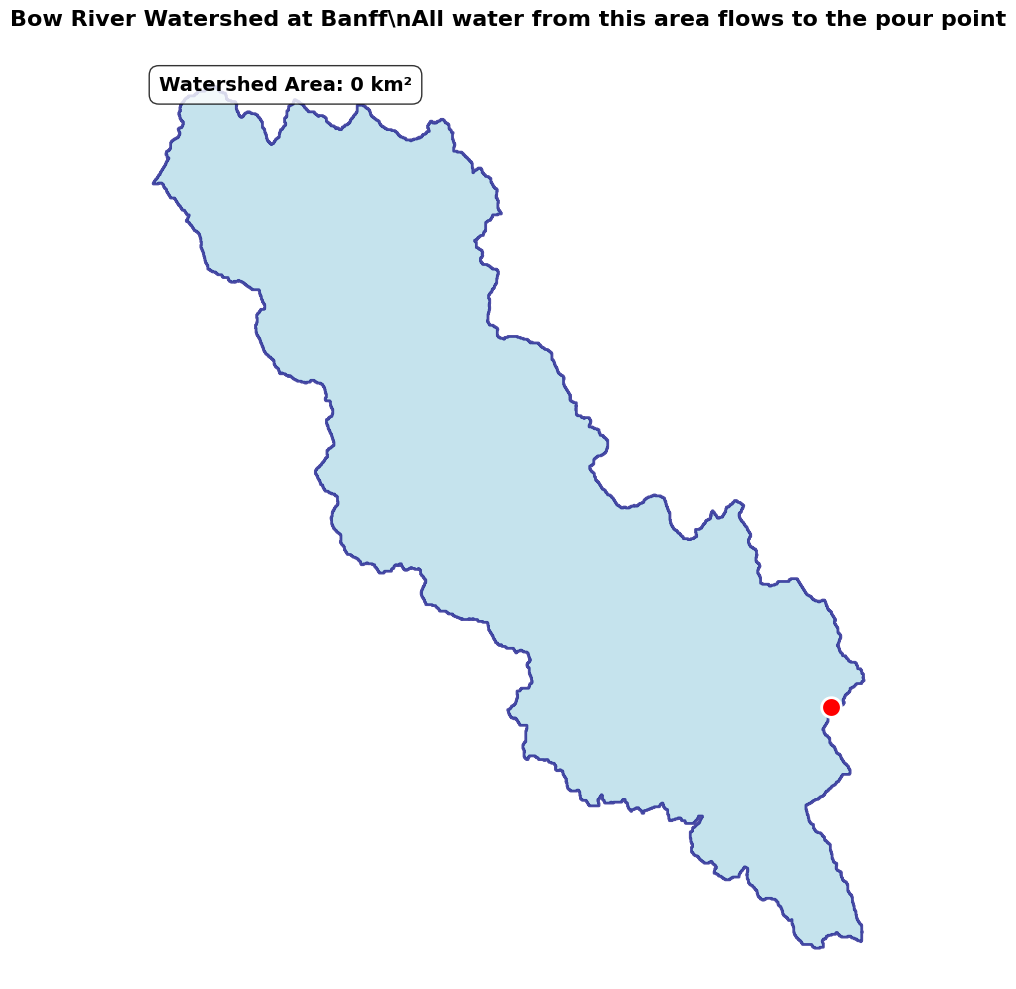

In [7]:
# Visualize the watershed
basin_path = project_dir / 'shapefiles' / 'river_basins'
if basin_path.exists():
    basin_files = list(basin_path.glob('*.shp'))
    
    if basin_files:
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Load watershed and pour point
        basin_gdf = gpd.read_file(basin_files[0])
        pour_point_gdf = gpd.read_file(pour_point_path)
        
        # Reproject for visualization
        basin_web = basin_gdf.to_crs(epsg=3857)
        pour_web = pour_point_gdf.to_crs(epsg=3857)
        
        # Plot watershed
        basin_web.plot(ax=ax, facecolor='lightblue', edgecolor='navy', 
                       linewidth=2, alpha=0.7)
        
        # Add pour point
        pour_web.plot(ax=ax, color='red', markersize=200, marker='o', 
                      edgecolor='white', linewidth=2, zorder=5)
                
        # Set extent
        minx, miny, maxx, maxy = basin_web.total_bounds
        pad = 5000
        ax.set_xlim(minx - pad, maxx + pad)
        ax.set_ylim(miny - pad, maxy + pad)
        
        # Add labels
        ax.text(minx + 1000, maxy - 1000,
                f'Watershed Area: {basin_gdf.geometry.area.sum() / 1e6:.0f} km²', 
                fontsize=14, 
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8),
                fontweight='bold')
        
        ax.set_title('Bow River Watershed at Banff\\nAll water from this area flows to the pour point', 
                    fontsize=16, fontweight='bold', pad=20)
        
        ax.axis('off')
        plt.tight_layout()
        plt.show()

## 8. Model Agnostic Data Pre-Processing - Observed data
For a lumped model, the entire watershed becomes a single Hydrologic Response Unit (HRU). This simplification assumes uniform characteristics across the watershed - obviously an approximation, but useful for many applications.


In [8]:
# Step 3: Model Agnostic Data Pre-Processing
print("=== Step 3: Model Agnostic Data Pre-Processing ===")

# Process observed data
print("Processing observed streamflow data...")
confluence.managers['data'].process_observed_data()

=== Step 3: Model Agnostic Data Pre-Processing ===
Processing observed streamflow data...
14:59:38 - INFO - Processing observed data


2025-05-11 14:59:38,090 - confluence_general - INFO - Processing observed data


14:59:38 - INFO - Processing WSC streamflow data from HYDAT database


2025-05-11 14:59:38,092 - confluence_general - INFO - Processing WSC streamflow data from HYDAT database


14:59:38 - INFO - Querying data from year 2018 to 2025


2025-05-11 14:59:38,096 - confluence_general - INFO - Querying data from year 2018 to 2025


14:59:38 - INFO - Retrieving discharge data for WSC station 05BB001 from HYDAT database


2025-05-11 14:59:38,097 - confluence_general - INFO - Retrieving discharge data for WSC station 05BB001 from HYDAT database


14:59:38 - INFO - Database path: /work/comphyd_lab/data/geospatial-data/hydat/Hydat.sqlite3


2025-05-11 14:59:38,099 - confluence_general - INFO - Database path: /work/comphyd_lab/data/geospatial-data/hydat/Hydat.sqlite3


14:59:38 - INFO - Time period: 2018 to 2025


2025-05-11 14:59:38,100 - confluence_general - INFO - Time period: 2018 to 2025


14:59:38 - INFO - Found station 05BB001 in HYDAT database


2025-05-11 14:59:38,115 - confluence_general - INFO - Found station 05BB001 in HYDAT database


14:59:38 - INFO - Station name: BOW RIVER AT BANFF


2025-05-11 14:59:38,116 - confluence_general - INFO - Station name: BOW RIVER AT BANFF


14:59:38 - INFO - Executing SQL query for daily flows...


2025-05-11 14:59:38,118 - confluence_general - INFO - Executing SQL query for daily flows...


14:59:38 - INFO - Retrieved 72 monthly records from HYDAT


2025-05-11 14:59:38,142 - confluence_general - INFO - Retrieved 72 monthly records from HYDAT


14:59:38 - INFO - Processed 2191 daily flow records


2025-05-11 14:59:38,227 - confluence_general - INFO - Processed 2191 daily flow records


14:59:38 - INFO - Date range: 2018-01-01 00:00:00 to 2023-12-31 00:00:00


2025-05-11 14:59:38,229 - confluence_general - INFO - Date range: 2018-01-01 00:00:00 to 2023-12-31 00:00:00


14:59:38 - INFO - Min flow: 5.809999942779541 m³/s


2025-05-11 14:59:38,231 - confluence_general - INFO - Min flow: 5.809999942779541 m³/s


14:59:38 - INFO - Max flow: 240.0 m³/s


2025-05-11 14:59:38,233 - confluence_general - INFO - Max flow: 240.0 m³/s


14:59:38 - INFO - Mean flow: 38.202441793769964 m³/s


2025-05-11 14:59:38,235 - confluence_general - INFO - Mean flow: 38.202441793769964 m³/s


14:59:39 - INFO - Processed streamflow data saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/observations/streamflow/preprocessed/Bow_at_Banff_lumped_streamflow_processed.csv


2025-05-11 14:59:39,147 - confluence_general - INFO - Processed streamflow data saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/observations/streamflow/preprocessed/Bow_at_Banff_lumped_streamflow_processed.csv


14:59:39 - INFO - Total rows in processed data: 52561


2025-05-11 14:59:39,149 - confluence_general - INFO - Total rows in processed data: 52561


14:59:39 - INFO - Number of non-null values: 52561


2025-05-11 14:59:39,151 - confluence_general - INFO - Number of non-null values: 52561


14:59:39 - INFO - Number of null values: 0


2025-05-11 14:59:39,153 - confluence_general - INFO - Number of null values: 0


14:59:39 - INFO - Successfully processed WSC data for station 05BB001


2025-05-11 14:59:39,160 - confluence_general - INFO - Successfully processed WSC data for station 05BB001


14:59:39 - INFO - Observed data processing completed successfully


2025-05-11 14:59:39,162 - confluence_general - INFO - Observed data processing completed successfully


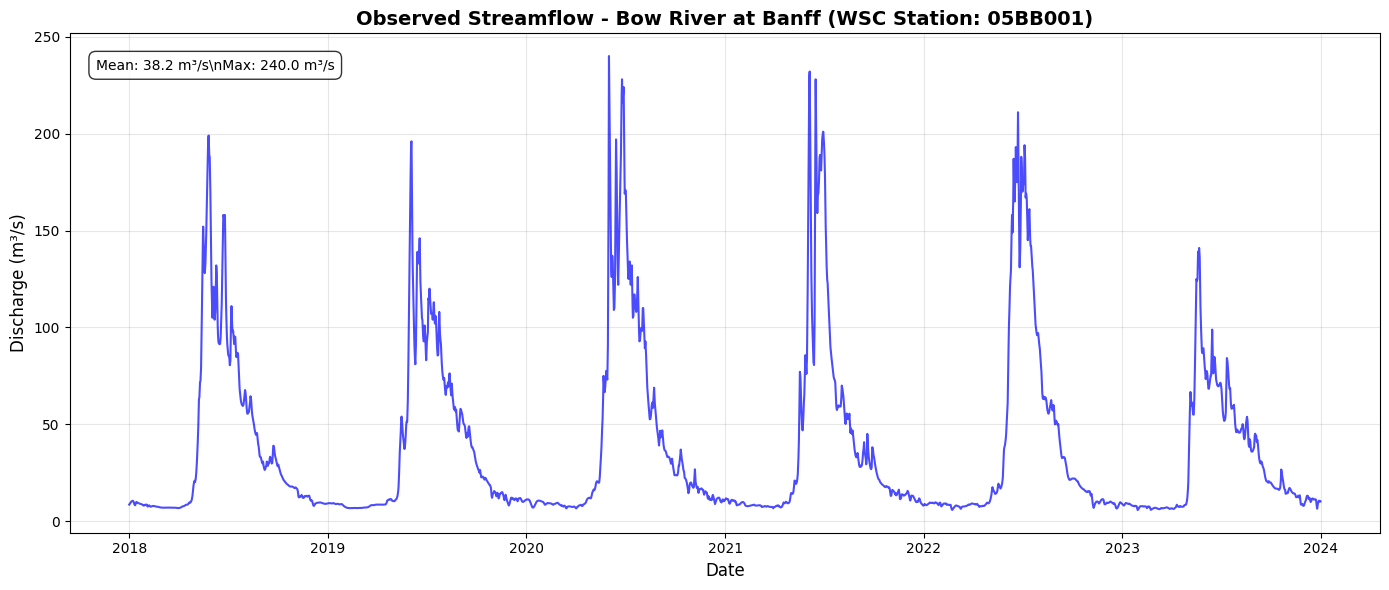

In [9]:
# Visualize observed streamflow data
obs_path = project_dir / 'observations' / 'streamflow' / 'preprocessed' / f"{confluence.config['DOMAIN_NAME']}_streamflow_processed.csv"
if obs_path.exists():
    obs_df = pd.read_csv(obs_path)
    obs_df['datetime'] = pd.to_datetime(obs_df['datetime'])
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(obs_df['datetime'], obs_df['discharge_cms'], 
            linewidth=1.5, color='blue', alpha=0.7)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Discharge (m³/s)', fontsize=12)
    ax.set_title(f'Observed Streamflow - Bow River at Banff (WSC Station: {confluence.config["STATION_ID"]})', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    ax.text(0.02, 0.95, f'Mean: {obs_df["discharge_cms"].mean():.1f} m³/s\\nMax: {obs_df["discharge_cms"].max():.1f} m³/s', 
            transform=ax.transAxes, 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8),
            verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

## 9. Model Agnostic Data Pre-Processing - Forcing data

In [10]:
# Acquire forcings
print(f"\nAcquiring forcing data: {confluence.config['FORCING_DATASET']}")
confluence.managers['data'].acquire_forcings()


Acquiring forcing data: ERA5
14:59:39 - INFO - Starting forcing data acquisition


2025-05-11 14:59:39,563 - confluence_general - INFO - Starting forcing data acquisition


14:59:43 - INFO - datatool job submitted successfully.


2025-05-11 14:59:43,130 - confluence_general - INFO - datatool job submitted successfully.


15:14:15 - INFO - All datatool array jobs completed.


2025-05-11 15:14:15,270 - confluence_general - INFO - All datatool array jobs completed.


15:14:15 - INFO - Meteorological data acquisition process completed


2025-05-11 15:14:15,273 - confluence_general - INFO - Meteorological data acquisition process completed


15:14:15 - INFO - Forcing data acquisition completed successfully


2025-05-11 15:14:15,275 - confluence_general - INFO - Forcing data acquisition completed successfully


## 10. Model Agnostic Data Pre-Processing - Remapping and zonal statistics

In [ ]:
# Run model-agnostic preprocessing
print("\nRunning model-agnostic preprocessing...")
confluence.managers['data'].run_model_agnostic_preprocessing()


Running model-agnostic preprocessing...
15:14:15 - INFO - Starting model-agnostic preprocessing


2025-05-11 15:14:15,283 - confluence_general - INFO - Starting model-agnostic preprocessing


15:14:15 - INFO - Running geospatial statistics


2025-05-11 15:14:15,559 - confluence_general - INFO - Running geospatial statistics


15:14:15 - INFO - Starting geospatial statistics calculation


2025-05-11 15:14:15,567 - confluence_general - INFO - Starting geospatial statistics calculation


15:14:15 - INFO - Calculating soil statistics


2025-05-11 15:14:15,577 - confluence_general - INFO - Calculating soil statistics
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:14:15,920 - pyogrio._io - INFO - Created 1 records


15:14:15 - INFO - Soil statistics saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment_intersection/with_soilgrids/default


2025-05-11 15:14:15,924 - confluence_general - INFO - Soil statistics saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment_intersection/with_soilgrids/default


15:14:15 - INFO - Calculating land statistics


2025-05-11 15:14:15,926 - confluence_general - INFO - Calculating land statistics
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:14:16,067 - pyogrio._io - INFO - Created 1 records


15:14:16 - INFO - Land statistics saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment_intersection/with_landclass/default


2025-05-11 15:14:16,077 - confluence_general - INFO - Land statistics saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment_intersection/with_landclass/default


15:14:16 - INFO - Calculating elevation statistics


2025-05-11 15:14:16,080 - confluence_general - INFO - Calculating elevation statistics


15:14:16 - INFO - Updating existing 'elev_mean' column


2025-05-11 15:14:16,165 - confluence_general - INFO - Updating existing 'elev_mean' column
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:14:16,187 - pyogrio._io - INFO - Created 1 records


15:14:16 - INFO - Elevation statistics saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment_intersection/with_dem/default


2025-05-11 15:14:16,191 - confluence_general - INFO - Elevation statistics saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment_intersection/with_dem/default


15:14:16 - INFO - Geospatial statistics completed: 0/3 steps skipped, 3/3 steps executed


2025-05-11 15:14:16,193 - confluence_general - INFO - Geospatial statistics completed: 0/3 steps skipped, 3/3 steps executed


15:14:16 - INFO - Running forcing resampling


2025-05-11 15:14:16,195 - confluence_general - INFO - Running forcing resampling


15:14:16 - INFO - Starting forcing data resampling process


2025-05-11 15:14:16,196 - confluence_general - INFO - Starting forcing data resampling process


15:14:16 - INFO - Creating ERA5 shapefile


2025-05-11 15:14:16,198 - confluence_general - INFO - Creating ERA5 shapefile


15:14:16 - INFO - Creating ERA5 shapefile


2025-05-11 15:14:16,203 - confluence_general - INFO - Creating ERA5 shapefile


15:14:16 - INFO - Using ERA5 file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/raw_data/domain_Bow_at_Banff_lumped_ERA5_merged_202202.nc


2025-05-11 15:14:16,219 - confluence_general - INFO - Using ERA5 file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/raw_data/domain_Bow_at_Banff_lumped_ERA5_merged_202202.nc


15:14:16 - INFO - ERA5 dimensions: lat=(6,), lon=(7,)


2025-05-11 15:14:16,552 - confluence_general - INFO - ERA5 dimensions: lat=(6,), lon=(7,)


15:14:16 - INFO - ERA5 grid spacings: half_dlat=0.125, half_dlon=0.125


2025-05-11 15:14:16,564 - confluence_general - INFO - ERA5 grid spacings: half_dlat=0.125, half_dlon=0.125


15:14:16 - INFO - Creating grid cell geometries


2025-05-11 15:14:16,570 - confluence_general - INFO - Creating grid cell geometries


15:14:16 - INFO - Multiple latitude values, creating grid


2025-05-11 15:14:16,578 - confluence_general - INFO - Multiple latitude values, creating grid


15:14:16 - INFO - Created 42 grid cell geometries


2025-05-11 15:14:16,585 - confluence_general - INFO - Created 42 grid cell geometries


15:14:16 - INFO - Creating GeoDataFrame


2025-05-11 15:14:16,590 - confluence_general - INFO - Creating GeoDataFrame


15:14:16 - INFO - GeoDataFrame created with 42 rows


2025-05-11 15:14:16,595 - confluence_general - INFO - GeoDataFrame created with 42 rows


15:14:16 - INFO - Calculating zonal statistics with DEM: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem/domain_Bow_at_Banff_lumped_elv.tif


2025-05-11 15:14:16,599 - confluence_general - INFO - Calculating zonal statistics with DEM: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem/domain_Bow_at_Banff_lumped_elv.tif


15:14:16 - INFO - Using sample of 42 grid cells for zonal statistics


2025-05-11 15:14:16,602 - confluence_general - INFO - Using sample of 42 grid cells for zonal statistics


15:14:16 - INFO - Processing elevation batch 1/3 (0 to 19)


2025-05-11 15:14:16,605 - confluence_general - INFO - Processing elevation batch 1/3 (0 to 19)
/home/darri.eythorsson/code/CONFLUENCE/utils/data/agnosticPreProcessor.py:373: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2338.127669533673' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gdf.loc[idx, 'elev_m'] = item['mean'] if item['mean'] is not None else -9999


15:14:16 - INFO - Processing elevation batch 2/3 (20 to 39)


2025-05-11 15:14:16,787 - confluence_general - INFO - Processing elevation batch 2/3 (20 to 39)


15:14:16 - INFO - Processing elevation batch 3/3 (40 to 41)


2025-05-11 15:14:16,986 - confluence_general - INFO - Processing elevation batch 3/3 (40 to 41)


15:14:17 - INFO - Elevation calculation complete


2025-05-11 15:14:17,004 - confluence_general - INFO - Elevation calculation complete


15:14:17 - INFO - Saving shapefile to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/forcing/forcing_ERA5.shp


2025-05-11 15:14:17,007 - confluence_general - INFO - Saving shapefile to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/forcing/forcing_ERA5.shp
2025-05-11 15:14:17,052 - pyogrio._io - INFO - Created 42 records


15:14:17 - INFO - ERA5 shapefile saved successfully to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/forcing/forcing_ERA5.shp


2025-05-11 15:14:17,055 - confluence_general - INFO - ERA5 shapefile saved successfully to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/forcing/forcing_ERA5.shp


15:14:17 - INFO - Starting forcing remapping process


2025-05-11 15:14:17,057 - confluence_general - INFO - Starting forcing remapping process


15:14:17 - INFO - Creating weighted forcing files in parallel


2025-05-11 15:14:17,059 - confluence_general - INFO - Creating weighted forcing files in parallel


15:14:17 - INFO - Found 60 forcing files to process


2025-05-11 15:14:17,062 - confluence_general - INFO - Found 60 forcing files to process


15:14:17 - INFO - Using 1 CPUs for parallel processing


2025-05-11 15:14:17,064 - confluence_general - INFO - Using 1 CPUs for parallel processing


15:14:17 - INFO - Found 0 already processed files


2025-05-11 15:14:17,090 - confluence_general - INFO - Found 0 already processed files


15:14:17 - INFO - Found 60 files that need processing


2025-05-11 15:14:17,092 - confluence_general - INFO - Found 60 files that need processing


15:14:17 - INFO - Processing 6 batches of up to 10 files each


2025-05-11 15:14:17,093 - confluence_general - INFO - Processing 6 batches of up to 10 files each


15:14:17 - INFO - Processing batch 1/6 with 10 files


2025-05-11 15:14:17,095 - confluence_general - INFO - Processing batch 1/6 with 10 files


15:14:17 - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201801.nc


2025-05-11 15:14:17,118 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201801.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:14:17,431 - pyogrio._io - INFO - Created 1 records


EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_394dcdf8_0/Bow_at_Banff_lumped_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 15:14:17,511 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_394dcdf8_0/Bow_at_Banff_lumped_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:14:17,590 - pyogrio._io - INFO - Created 1 records
2025-05-11 15:14:17,613 - pyogrio._io - INFO - Created 42 records
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_

Ended at date and time 2025-05-11 15:14:18.976897
It took 1.611907 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/raw_data/domain_Bow_at_Banff_lumped_ERA5_merged_201801.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/basin_averaged_data/Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201801.nc 
Started at date and time 2025-05-11 15:14:19.065367 
Ended at date and time 2025-05-11 15:14:41.847840 
It took 22.782473 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:14:41 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_lumped_ERA5_merged_201801.nc in 24.82 seconds


2025-05-11 15:14:41,933 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_lumped_ERA5_merged_201801.nc in 24.82 seconds


15:14:41 - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201802.nc


2025-05-11 15:14:41,935 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201802.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:14:42,208 - pyogrio._io - INFO - Created 1 records


EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_25299ea2_0/Bow_at_Banff_lumped_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 15:14:42,253 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_25299ea2_0/Bow_at_Banff_lumped_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:14:42,296 - pyogrio._io - INFO - Created 1 records
2025-05-11 15:14:42,314 - pyogrio._io - INFO - Created 42 records
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_

Ended at date and time 2025-05-11 15:14:42.637824
It took 0.465949 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/raw_data/domain_Bow_at_Banff_lumped_ERA5_merged_201802.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/basin_averaged_data/Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201802.nc 
Started at date and time 2025-05-11 15:14:42.713374 
Ended at date and time 2025-05-11 15:15:03.219357 
It took 20.505983 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:03 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_lumped_ERA5_merged_201802.nc in 21.34 seconds


2025-05-11 15:15:03,279 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_lumped_ERA5_merged_201802.nc in 21.34 seconds


15:15:03 - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201803.nc


2025-05-11 15:15:03,282 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201803.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:15:03,530 - pyogrio._io - INFO - Created 1 records


EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_7b861cbd_0/Bow_at_Banff_lumped_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 15:15:03,589 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_7b861cbd_0/Bow_at_Banff_lumped_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:15:03,645 - pyogrio._io - INFO - Created 1 records
2025-05-11 15:15:03,668 - pyogrio._io - INFO - Created 42 records
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_

Ended at date and time 2025-05-11 15:15:04.016545
It took 0.549711 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/raw_data/domain_Bow_at_Banff_lumped_ERA5_merged_201803.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/basin_averaged_data/Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201803.nc 
Started at date and time 2025-05-11 15:15:04.092034 
Ended at date and time 2025-05-11 15:15:26.714272 
It took 22.622238 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:26 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_lumped_ERA5_merged_201803.nc in 23.51 seconds


2025-05-11 15:15:26,794 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_lumped_ERA5_merged_201803.nc in 23.51 seconds


15:15:26 - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201804.nc


2025-05-11 15:15:26,797 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201804.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:15:27,051 - pyogrio._io - INFO - Created 1 records


EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_8d5cdd17_0/Bow_at_Banff_lumped_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 15:15:27,105 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_8d5cdd17_0/Bow_at_Banff_lumped_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:15:27,161 - pyogrio._io - INFO - Created 1 records
2025-05-11 15:15:27,182 - pyogrio._io - INFO - Created 42 records
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_

Ended at date and time 2025-05-11 15:15:27.547788
It took 0.536179 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/raw_data/domain_Bow_at_Banff_lumped_ERA5_merged_201804.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/basin_averaged_data/Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201804.nc 
Started at date and time 2025-05-11 15:15:27.634010 
Ended at date and time 2025-05-11 15:15:49.479467 
It took 21.845457 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:15:49 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_lumped_ERA5_merged_201804.nc in 22.78 seconds


2025-05-11 15:15:49,574 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_lumped_ERA5_merged_201804.nc in 22.78 seconds


15:15:49 - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201805.nc


2025-05-11 15:15:49,576 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201805.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:15:49,901 - pyogrio._io - INFO - Created 1 records


EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_5dbfba3c_0/Bow_at_Banff_lumped_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 15:15:49,963 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_5dbfba3c_0/Bow_at_Banff_lumped_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:15:50,051 - pyogrio._io - INFO - Created 1 records
2025-05-11 15:15:50,105 - pyogrio._io - INFO - Created 42 records
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_

Ended at date and time 2025-05-11 15:15:50.715681
It took 0.876308 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/raw_data/domain_Bow_at_Banff_lumped_ERA5_merged_201805.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/basin_averaged_data/Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201805.nc 
Started at date and time 2025-05-11 15:15:50.806926 
Ended at date and time 2025-05-11 15:16:13.456395 
It took 22.649469 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:13 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_lumped_ERA5_merged_201805.nc in 23.99 seconds


2025-05-11 15:16:13,567 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_lumped_ERA5_merged_201805.nc in 23.99 seconds


15:16:13 - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201806.nc


2025-05-11 15:16:13,569 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201806.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:16:13,811 - pyogrio._io - INFO - Created 1 records


EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_edcdb891_0/Bow_at_Banff_lumped_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 15:16:13,857 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_edcdb891_0/Bow_at_Banff_lumped_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:16:13,909 - pyogrio._io - INFO - Created 1 records
2025-05-11 15:16:13,932 - pyogrio._io - INFO - Created 42 records
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_

Ended at date and time 2025-05-11 15:16:14.261252
It took 0.489716 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/raw_data/domain_Bow_at_Banff_lumped_ERA5_merged_201806.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/basin_averaged_data/Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201806.nc 
Started at date and time 2025-05-11 15:16:14.336385 
Ended at date and time 2025-05-11 15:16:35.857211 
It took 21.520826 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:35 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_lumped_ERA5_merged_201806.nc in 22.35 seconds


2025-05-11 15:16:35,921 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_lumped_ERA5_merged_201806.nc in 22.35 seconds


15:16:35 - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201807.nc


2025-05-11 15:16:35,923 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201807.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:16:36,159 - pyogrio._io - INFO - Created 1 records


EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_961fd18f_0/Bow_at_Banff_lumped_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 15:16:36,207 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_961fd18f_0/Bow_at_Banff_lumped_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:16:36,251 - pyogrio._io - INFO - Created 1 records
2025-05-11 15:16:36,269 - pyogrio._io - INFO - Created 42 records
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_

Ended at date and time 2025-05-11 15:16:36.612349
It took 0.490765 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/raw_data/domain_Bow_at_Banff_lumped_ERA5_merged_201807.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/basin_averaged_data/Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201807.nc 
Started at date and time 2025-05-11 15:16:36.681601 
Ended at date and time 2025-05-11 15:16:58.862098 
It took 22.180497 seconds to finish the remapping of variable(s) 
---------------------
---------------------
15:16:58 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_lumped_ERA5_merged_201807.nc in 22.99 seconds


2025-05-11 15:16:58,913 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_lumped_ERA5_merged_201807.nc in 22.99 seconds


15:16:58 - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201808.nc


2025-05-11 15:16:58,914 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_lumped_ERA5_merged_201808.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:16:59,133 - pyogrio._io - INFO - Created 1 records


EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_cd3ab69c_0/Bow_at_Banff_lumped_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 15:16:59,180 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/forcing/temp_easymore_cd3ab69c_0/Bow_at_Banff_lumped_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 15:16:59,232 - pyogrio._io - INFO - Created 1 records
2025-05-11 15:16:59,253 - pyogrio._io - INFO - Created 42 records
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_

Ended at date and time 2025-05-11 15:16:59.586743
It took 0.491322 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4


## 12. Model-Specific - Preprocessing
Now we prepare inputs specific to our chosen hydrological model (SUMMA in this case). Each model has its own requirements for input format and configuration.

In [ ]:
# Step 4: Model Specific Processing and Initialization
print("=== Step 4: Model Specific Processing and Initialization ===")

# Preprocess models
print(f"Preparing {confluence.config['HYDROLOGICAL_MODEL']} input files...")
confluence.managers['model'].preprocess_models()

## 13. Model-Specific - Instantiation

In [ ]:
# Run models
print(f"\nRunning {confluence.config['HYDROLOGICAL_MODEL']} model...")
confluence.managers['model'].run_models()

print("\nModel run complete")

## 11. Model Agnostic Data Pre-Processing - Benchmarking

In [ ]:
# Run benchmarking
print("\nRunning benchmarking analysis...")
benchmark_results = confluence.managers['analysis'].run_benchmarking()

## 14. Optional Steps - Optimization and Analysis

In [ ]:
# Step 5 & 6: Optional Steps (Optimization and Analysis)
print("=== Step 5 & 6: Optional Steps ===")

# Check if optimization is enabled
if confluence.config.get('RUN_ITERATIVE_OPTIMISATION', False):
    print("Running model calibration...")
    optimization_results = confluence.managers['optimization'].calibrate_model()
else:
    print("Model calibration skipped (RUN_ITERATIVE_OPTIMISATION = False)")

# Check if emulation is enabled
if confluence.config.get('RUN_LARGE_SAMPLE_EMULATION', False) or confluence.config.get('RUN_RANDOM_FOREST_EMULATION', False):
    print("Running parameter emulation...")
    emulation_results = confluence.managers['optimization'].run_emulation()
else:
    print("Parameter emulation skipped")

# Check if decision analysis is enabled
if confluence.config.get('RUN_DECISION_ANALYSIS', False):
    print("Running decision analysis...")
    decision_results = confluence.managers['analysis'].run_decision_analysis()
else:
    print("Decision analysis skipped")

# Check if sensitivity analysis is enabled
if confluence.config.get('RUN_SENSITIVITY_ANALYSIS', False):
    print("Running sensitivity analysis...")
    sensitivity_results = confluence.managers['analysis'].run_sensitivity_analysis()
else:
    print("Sensitivity analysis skipped")

## 15 - Result Analysis and Evaluation

In [ ]:
# Step 7: Result Analysis and Evaluation
print("=== Step 7: Result Analysis and Evaluation ===")

# Postprocess results
print("Post-processing model results...")
confluence.managers['model'].postprocess_results()

# Get workflow status
status = confluence.workflow_orchestrator.get_workflow_status()
print(f"\nWorkflow Status:")
print(f"Total steps: {status['total_steps']}")
print(f"Completed steps: {status['completed_steps']}")
print(f"Pending steps: {status['pending_steps']}")

# Display final summary
print("\n=== Workflow Complete ===")
print(f"Project: {confluence.config['DOMAIN_NAME']}")
print(f"Experiment: {confluence.config['EXPERIMENT_ID']}")
print(f"Model: {confluence.config['HYDROLOGICAL_MODEL']}")
print(f"\nKey outputs:")
print(f"  - Watershed boundary: {project_dir}/shapefiles/river_basins/")
print(f"  - Model configuration: {project_dir}/settings/{confluence.config['HYDROLOGICAL_MODEL']}/")
print(f"  - Simulation results: {project_dir}/simulations/{confluence.config['EXPERIMENT_ID']}/")
print(f"  - Performance metrics: {project_dir}/evaluation/")
print(f"  - Visualizations: {project_dir}/plots/")

## 16: Alternative - Run Complete Workflow

In [ ]:
# Alternative: Run the complete workflow in one step
# (Uncomment to use this instead of the step-by-step approach)

# confluence.run_workflow()

## Summary: Understanding the CONFLUENCE Workflow
Congratulations! You've completed a full lumped basin modeling workflow with CONFLUENCE. Let's reflect on what we accomplished and how CONFLUENCE helped navigate the complex decision tree of hydrological modeling.
The Decision Tree We Navigated:

### Project Organization: Established a consistent structure for all files
Domain Definition: From pour point → watershed boundary → single HRU
Data Acquisition: Gathered forcing data, observations, and static attributes
Model Configuration: Set up SUMMA with appropriate parameters
Simulation: Ran the model for our specified period
Evaluation: Compared results with observations

## Next Steps You Could Try:

### Experiment with different models (change HYDROLOGICAL_MODEL)
Try distributed modeling (change SPATIAL_MODE to 'Distributed')
Calibrate the model (use the optimization module)
Analyze model sensitivity to different parameters
Compare multiple model structures (decision analysis)
